### 一、该脚本尝试实现：  
1.使用autoencoder unsupervised pretraining来在一个标记很少的小数据集上训练准确率很高的分类器。  
(这个应用应该是很有意义的。因为无标签数据集很好搜集，但是有标签数据集却不好找。在大量无标签数据集上预训练，再将网络一部分用于小数据集训练)  
2.使用convolutional autoencoder尝试重建cifar10（结果不是很理想...可能是网络架构不够深，或者超参数不够优秀。具体原因还需要进一步探究）  

＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝分割线＝＝＝＝＝＝＝＝＝＝＝＝＝＝  
### 二、总结收获  
1.使用keras拆解与重组模型，如①从autoencoder中取出coding_layer,与input合成encoder,在用coding_layer接后面的层，得到decoder  
②后面将encoder最后一层摘出来，后面接分类器  
2.复习了使用matplotlib notebook绘制动态图进行可视化的技巧  
3.学习搭建convolutional autoencoder来重建图像  
＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝分割线＝＝＝＝＝＝＝＝＝＝＝＝＝＝  
### 三、值得注意的细节  
1.encoder,decoder的重组  
2.重要：注意区分keras中的Model,layer,以及layer的output(tensor)  
Functional model每一层最后小括号里的是上一次的输出output，要求类型为tensor.建立过模型之后，model=Model(inputs=xx,outputs=xx)建立的是model, model.layers[-1]得到的是最后一层这个object。  
3.总结一些常用的resize函数  
如scipy.misc.imresize  
＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝分割线＝＝＝＝＝＝＝＝＝＝＝＝＝＝   
### 四、未解决的问题：  
使用convolutional autoencoder对cifar10的重建结果很差。需要对模型进一步优化，调整超参数来取得更好的效果  

任务1：在mnist上train一个stacked AutoEncoder,然后将lower layers在另一个用于分类器的neural network中进行reuse,并在该网络训练利用较少的标签训练一个分类器

## 第一部分:　在mnist上训练autoencoder(无监督)

In [1]:
from keras.datasets import mnist
import numpy as np
from keras import Input,Model
from keras.layers import Dense

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


第一步：准备一个无标签的较大数据集，用于训练AE

In [2]:
(X,_),(X_clf,y_clf) = mnist.load_data()
X = X.astype('float')/255.
X_clf = X_clf.astype('float')/255.

In [3]:
input_shape_conv = X.shape[1:]
input_shape_dense = np.multiply.accumulate(X.shape[1:])[-1]
print(X.shape,input_shape_conv,input_shape_dense)

(60000, 28, 28) (28, 28) 784


In [4]:
train_set_ratio = 0.9
rnd = np.random.random(len(X))
train_ind = rnd<train_set_ratio
val_ind = rnd>=train_set_ratio


In [5]:
#加载进来的cifar数据集已经shuffle过了，所以直接划分train/val
X_val = X[val_ind]
X_train = X[train_ind]
print(X_train.shape,X_val.shape)
X_train = X_train.reshape(X_train.shape[0],-1)
X_val = X_val.reshape(X_val.shape[0],-1)

(54004, 28, 28) (5996, 28, 28)


In [6]:
print(X_train.shape,X_val.shape)

(54004, 784) (5996, 784)


首先使用Dense layers构建一个deep AE

In [7]:
input_img = Input(shape=(input_shape_dense,),dtype='float',name='Input_layer') #注意这里第一层dense输入要为(3072,)
x = Dense(units=512,activation='relu',name='h1_layer')(input_img)
x = Dense(units=256,activation='relu',name='h2_layer')(x)
encoded = Dense(units=128,activation='relu',name='coding_layer')(x)
x = Dense(units=256,activation='relu',name='h4_layer')(encoded)
x = Dense(units=512,activation='relu',name='h5_layer')(x)
decoded = Dense(units=input_shape_dense,activation='sigmoid',name='decoded')(x) 
#????????????????????????????????????????????????????????????????????????????????
#问题：为什么AE的output要使用sigmoid?重建图像不是应该不使用activation吗？（Hands on书上没有使用）
AutoEncoder = Model(input_img,decoded)

顺便创建一个encoder model和一个decoder model，可能会有后续使用  
这里在创建decoder时要注意：由于官方教程用的三层AE,所以可以对decoded_layer函数直接call　encoded_input，维度一致。  
但我这里是deep ae，最后一层decoded_layer()要接受512维度而不是encoded_dim=128.解决：参考stack overflow:重新定义连续多层  
https://stackoverflow.com/questions/44472693/how-to-decode-encoded-data-from-deep-autoencoder-in-keras-unclarity-in-tutorial 

In [8]:
encoder = Model(input_img,encoded)
encoded_dim = 128
encoded_input = Input(shape=(encoded_dim,),name='encoded_layer')
# decoded_layer = AutoEncoder.layers[-1]
# decoder = Model(input= encoded_input,output = decoded)
deco = AutoEncoder.layers[-3](encoded_input)
deco = AutoEncoder.layers[-2](deco)
deco = AutoEncoder.layers[-1](deco)
decoder = Model(input = encoded_input, output = deco)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("en...)`
  if __name__ == '__main__':


In [9]:
AutoEncoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     (None, 784)               0         
_________________________________________________________________
h1_layer (Dense)             (None, 512)               401920    
_________________________________________________________________
h2_layer (Dense)             (None, 256)               131328    
_________________________________________________________________
coding_layer (Dense)         (None, 128)               32896     
_________________________________________________________________
h4_layer (Dense)             (None, 256)               33024     
_________________________________________________________________
h5_layer (Dense)             (None, 512)               131584    
_________________________________________________________________
decoded (Dense)              (None, 784)               402192    
Total para

In [10]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     (None, 784)               0         
_________________________________________________________________
h1_layer (Dense)             (None, 512)               401920    
_________________________________________________________________
h2_layer (Dense)             (None, 256)               131328    
_________________________________________________________________
coding_layer (Dense)         (None, 128)               32896     
Total params: 566,144
Trainable params: 566,144
Non-trainable params: 0
_________________________________________________________________


In [11]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_layer (InputLayer)   (None, 128)               0         
_________________________________________________________________
h4_layer (Dense)             (None, 256)               33024     
_________________________________________________________________
h5_layer (Dense)             (None, 512)               131584    
_________________________________________________________________
decoded (Dense)              (None, 784)               402192    
Total params: 566,800
Trainable params: 566,800
Non-trainable params: 0
_________________________________________________________________


In [12]:
AutoEncoder.compile(loss='binary_crossentropy',optimizer='adam')  #重建图像与原图像，只有两个类别，所以用binary
AutoEncoder.fit(X_train,X_train,epochs=1,batch_size=128,shuffle=True,validation_data=(X_val,X_val))

Train on 54004 samples, validate on 5996 samples
Epoch 1/1
54004/54004 [==============================] - 5s 84us/step - loss: 0.1588 - val_loss: 0.1039


In [13]:
import matplotlib.pyplot as plt
def plot_image(image,shape=input_shape_conv):
    plt.imshow(image.reshape(shape),cmap='gray')
    plt.axis('off')
def plot_decoded_img(n_examples,recon,X_val):
    fig = plt.figure(figsize=(n_examples*2,n_examples))
    for i in range(n_examples):
        plt.subplot(2,n_examples,i+1)
        plot_image(recon[i])
        plt.subplot(2,n_examples,i+n_examples+1)
        plot_image(X_val[i])

可视化重建图像

In [14]:
encoded_image = encoder.predict(X_val)
decoded_image = decoder.predict(encoded_image)

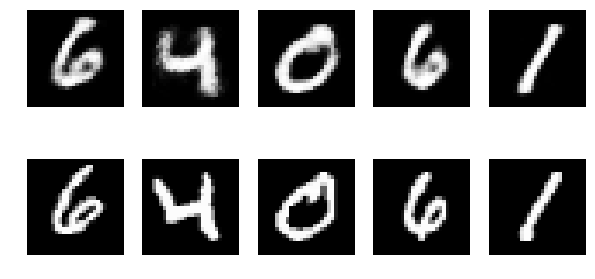

In [15]:
# plot_image(decoded_image[120])
plot_decoded_img(5,decoded_image,X_val)

小实验：将decoder看做一个generator,可以利用输入的vector生成数字。改变该输入的vector，观察输出图像的变化  
（vector z的可解释性） 

注意：不要decoder接收的输入不是一个向量，而是一个矩阵。所以先对z vector扩展维度。否则报错：  
ValueError: Error when checking : expected encoded_layer to have shape (128,) but got array with shape (1,)


<IPython.core.display.Javascript object>


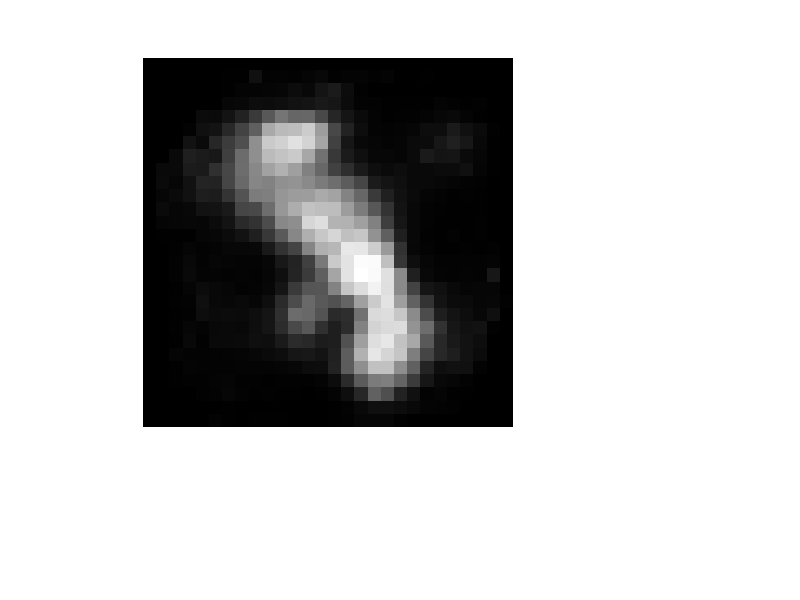

In [16]:
#实验一：笑容渐渐消失
%matplotlib notebook
fig = plt.figure()
for weight in list(np.linspace(0,1,10)):
    fig.clf()
    e_test = (weight*encoded_image[10]+(1-weight)*encoded_image[2])/2
    d_test = decoder.predict(np.array([e_test]))
    plot_image(d_test)
    fig.canvas.draw()
    plt.pause(0.3)

<IPython.core.display.Javascript object>


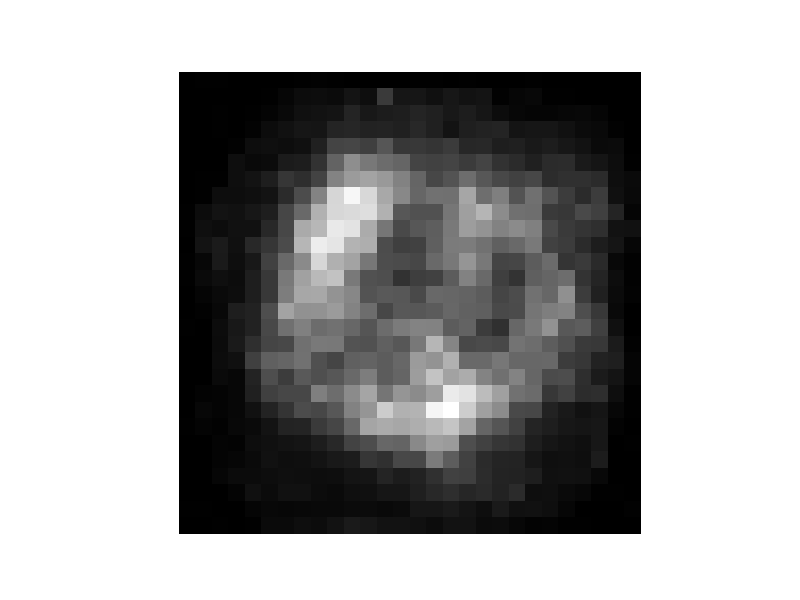

In [17]:
#实验二：将原始z vector中的一些元素改变
%matplotlib notebook
z1 = e_test.copy()
fig = plt.figure()
for n_zeros in range(128):
    fig.clf()
    z1[:n_zeros]=1
    g1 = decoder.predict(np.array([z1]))
    plot_image(g1)
    fig.canvas.draw()
    plt.pause(0.1)

## 第二部分：使用autoencoder的encoder，在sklearn的digits（小数据集）上训练分类器

使用encoder部分，后接classifier变成分类器，对sklean中的digits进行分类(digits是一个小数据集).由于mnist 28*28,digits 8*8，因此要resize digits数据集以适应网络输入尺寸

In [18]:
from sklearn.datasets import load_digits
import scipy
from sklearn.model_selection import train_test_split
import keras
digits = load_digits()
X_digits = digits.data
y_digits = digits.target
y_digits_compact = y_digits
y_digits = keras.utils.to_categorical(y_digits)
print(X_digits.shape)
X_new=np.zeros((len(X_digits),28*28))
for i in range(len(X_digits)):
    X_new[i]=scipy.misc.imresize(X_digits[i].reshape(8,-1),(28,28)).reshape(1,-1)
# tt = scipy.misc.imresize(X_digits[10].reshape(8,-1),(28,28))
# print(tt.shape)
print(X_new.shape)
X_new = X_new.astype('float')/255
X_train,X_test,y_train,y_test = train_test_split(X_new,y_digits)

(1797, 64)
(1797, 784)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


现在需要在keras functional model中，尝试在已有模型上添加层  
错误类型：ValueError: Layer fc1 was called with an input that isn't a symbolic tensor. Received type: <class 'keras.layers.core.Dense'>. Full input: [<keras.layers.core.Dense object at 0x7f686bfac390>]. All inputs to the layer should be tensors.


In [19]:
coding_layer = encoder.layers[-1] #encoder是一个Model
encoded = coding_layer.output 
#注意：coding_layer的数据类型不是一个tensor。在Functional model中搭建层用的是tensor。所以不能直接拿着encoder.layers[-1]使用
#     我们要找到的是coding_layer这一层的输出encoded,即一个tensor，Functional model接收的是上一层的输出tensor
clf = Dense(units=128,activation='relu',name='fc1')(encoded)
clf = Dense(units=10,activation='softmax',name='fc2')(clf)
Final_classifier = Model(inputs=input_img, outputs=clf)
Final_classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
Final_classifier.fit(X_train,y_train,epochs=10,batch_size=32)
preds = Final_classifier.predict(X_test)
accuracy = np.mean(np.argmax(preds,axis=1)==np.argmax(y_test,axis=1))
print('最终准确绿为：　',accuracy)

Epoch 1/10
1347/1347 [==============================] - 0s 249us/step - loss: 1.1722 - acc: 0.6667
Epoch 2/10
1347/1347 [==============================] - 0s 164us/step - loss: 0.2437 - acc: 0.9131
Epoch 3/10
1347/1347 [==============================] - 0s 184us/step - loss: 0.1813 - acc: 0.9488
Epoch 4/10
1347/1347 [==============================] - 0s 181us/step - loss: 0.1451 - acc: 0.9540
Epoch 5/10
1347/1347 [==============================] - 0s 182us/step - loss: 0.1298 - acc: 0.9525
Epoch 6/10
1347/1347 [==============================] - 0s 183us/step - loss: 0.1192 - acc: 0.9592
Epoch 7/10
1347/1347 [==============================] - 0s 185us/step - loss: 0.1124 - acc: 0.9607
Epoch 8/10
1347/1347 [==============================] - 0s 186us/step - loss: 0.0359 - acc: 0.9903
Epoch 9/10
1347/1347 [==============================] - 0s 188us/step - loss: 0.0410 - acc: 0.9844
Epoch 10/10
1347/1347 [==============================] - 0s 188us/step - loss: 0.0675 - acc: 0.9725
最终准确绿为：　 

## 第三部分.CIRFAR10重建  
实验结果表明：使用MLP搭建的深度AE在学习cifar10时很难收敛。(loss只能降到0.5附件)  
故尝试使用Convolutional Autoencoder

In [1]:
from keras.datasets import cifar10
import numpy as np
from keras import Input,Model
from keras.layers import Dense,Conv2D,MaxPool2D,UpSampling2D

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


第一步：准备一个无标签的较大数据集，用于训练AE

In [2]:
(X,_),(X_clf,y_clf) = cifar10.load_data()
X = X.astype('float')/255.
X_clf = X_clf.astype('float')/255.

In [3]:
input_shape_conv = X.shape[1:]
input_shape_dense = np.multiply.accumulate(X.shape[1:])[-1]
print(X.shape,input_shape_conv,input_shape_dense)

(50000, 32, 32, 3) (32, 32, 3) 3072


In [4]:
train_set_ratio = 0.9
rnd = np.random.random(len(X))
train_ind = rnd<train_set_ratio
val_ind = rnd>=train_set_ratio


In [5]:
#加载进来的cifar数据集已经shuffle过了，所以直接划分train/val
X_val = X[val_ind]
X_train = X[train_ind]
print(X_train.shape,X_val.shape)
# X_train = X_train.reshape(X_train.shape[0],-1) #使用conv ae不需要reshape
# X_val = X_val.reshape(X_val.shape[0],-1)

(45149, 32, 32, 3) (4851, 32, 32, 3)


In [6]:
print(X_train.shape,X_val.shape)

(45149, 32, 32, 3) (4851, 32, 32, 3)


首先使用Dense layers构建一个deep AE  
注意：①与前半部分maxpooling相对应，后半部分对称的层应该使用upsampling  
②Conv2D函数默认的padding参数不是'same'而是'valid'

In [7]:
input = Input(shape = input_shape_conv,name='inputs_cifar')
x = Conv2D(filters=16,kernel_size=3,strides=1,padding='same',activation='relu',name = 'hidden1')(input)
x = MaxPool2D((2,2))(x)
x = Conv2D(filters=8,kernel_size=3,strides=1,padding='same',activation='relu',name = 'hidden2')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(filters=8,kernel_size=3,strides=1,padding='same',activation='relu',name = 'hidden3')(x)
encoded = MaxPool2D((2,2))(x) #输出尺寸：(4,4,8)

x = Conv2D(filters=8,kernel_size=3,strides=1,padding='same',activation='relu',name = 'hidden4')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(filters=8,kernel_size=3,strides=1,padding='same',activation='relu',name = 'hidden5')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(filters=16,kernel_size=3,strides=1,padding='same',activation='relu',name = 'hidden6')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(filters=3,kernel_size=3,padding='same',activation='sigmoid',name='decoded')(x)
autoencoder = Model(inputs=input,outputs=decoded)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')

In [8]:
#同时定义一下encoder和decoder模型
encoder = Model(inputs=input,outputs=encoded)
decoder_input_shape = encoder.layers[-1].output_shape
decoder_input = Input(decoder_input_shape[1:]) 
d = Conv2D(filters=8,kernel_size=3,strides=1,padding='same',
                         activation='relu',name='deco_h1')(decoder_input)
d = UpSampling2D((2,2))(d)
d = Conv2D(filters=8,kernel_size=3,strides=1,padding='same',
                         activation='relu',name='deco_h2')(d)
d = UpSampling2D((2,2))(d)
d = Conv2D(filters=16,kernel_size=3,strides=1,padding='same',
                         activation='relu',name='deco_h3')(d)
d = UpSampling2D((2,2))(d)
#注意最后深度回到３
deco_op = Conv2D(filters=3,kernel_size=3,padding='same',activation='sigmoid',name = 'deco_op')(d)
decoder = Model(inputs=decoder_input,outputs=deco_op)  

In [9]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cifar (InputLayer)    (None, 32, 32, 3)         0         
_________________________________________________________________
hidden1 (Conv2D)             (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
hidden2 (Conv2D)             (None, 16, 16, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
hidden3 (Conv2D)             (None, 8, 8, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
Total para

In [10]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 4, 8)           0         
_________________________________________________________________
deco_h1 (Conv2D)             (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
deco_h2 (Conv2D)             (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
deco_h3 (Conv2D)             (None, 16, 16, 16)        1168      
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 32, 32, 16)        0         
__________

In [11]:
decoder.layers[-1].output_shape

(None, 32, 32, 3)

In [14]:
autoencoder.fit(X_train,X_train,epochs=20,batch_size=128,shuffle=True,validation_data=(X_val,X_val))

Train on 45149 samples, validate on 4851 samples
Epoch 1/20
45149/45149 [==============================] - 5s 113us/step - loss: 0.5790 - val_loss: 0.5767
Epoch 2/20
45149/45149 [==============================] - 5s 112us/step - loss: 0.5789 - val_loss: 0.5757
Epoch 3/20
45149/45149 [==============================] - 5s 112us/step - loss: 0.5788 - val_loss: 0.5758
Epoch 4/20
45149/45149 [==============================] - 5s 112us/step - loss: 0.5786 - val_loss: 0.5754
Epoch 5/20
45149/45149 [==============================] - 5s 111us/step - loss: 0.5784 - val_loss: 0.5753
Epoch 6/20
45149/45149 [==============================] - 5s 112us/step - loss: 0.5782 - val_loss: 0.5752
Epoch 7/20
45149/45149 [==============================] - 5s 111us/step - loss: 0.5781 - val_loss: 0.5748
Epoch 8/20
45149/45149 [==============================] - 5s 110us/step - loss: 0.5779 - val_loss: 0.5747
Epoch 9/20
45149/45149 [==============================] - 5s 112us/step - loss: 0.5778 - val_loss: 0.57

In [15]:
import matplotlib.pyplot as plt
def plot_image(image,shape=input_shape_conv):
    plt.imshow(image.reshape(shape))
    plt.axis('off')

可视化重建图像

In [23]:
# encoded_image = encoder.predict(X_val)
# decoded_image = decoder.predict(encoded_image)
decoded_image = autoencoder.predict(X_val)

In [25]:
import matplotlib.pyplot as plt
def plot_image(image,shape=input_shape_conv):
    plt.imshow(image.reshape(shape),cmap='gray')
    plt.axis('off')
def plot_decoded_img(n_examples,recon,X_val):
    fig = plt.figure(figsize=(n_examples*2,n_examples))
    for i in range(n_examples):
        plt.subplot(2,n_examples,i+1)
        plot_image(recon[i])
        plt.subplot(2,n_examples,i+n_examples+1)
        plot_image(X_val[i])

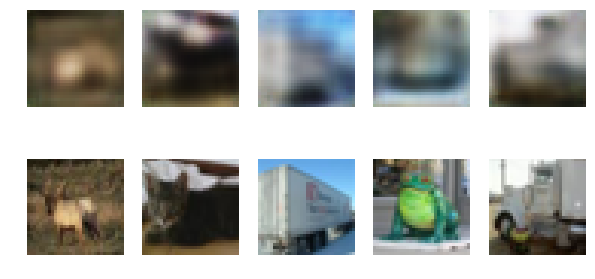

In [26]:
plot_decoded_img(5,decoded_image,X_val)